In [13]:
import os, pickle, sys, time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import seaborn as sns; sns.set_theme()
import warnings
from tqdm import tqdm, trange
from pprint import pprint
from tqdm import tqdm
from scipy.stats import pearsonr
import threading
from termcolor import cprint
from multiprocessing import Pool
import scipy
from numba import njit, jit, prange
from scipy.sparse import csr_matrix




import networkx as nx
from sklearn.cluster import SpectralClustering
from scipy.sparse import csgraph

from sknetwork.clustering import Louvain, modularity
from sknetwork.linalg import normalize
from sknetwork.utils import bipartite2undirected, membership_matrix

def permuteISIs(df): 
    df_ = df.sort_values(['neuronid', 'spiketime'])
    for n in trange(df.neuronid.max()+1):
        # get spts
        x = df_[df_.neuronid == n].spiketime.to_numpy()
        if x.shape[0] < 3:
            continue
        # from spts to ISIs
        d = np.diff(np.insert(x, 0, 0.0))
        np.random.shuffle(d)
        # from ISI back to spts
        x_ = np.cumsum(d)
        df_.loc[df_.neuronid == n, 'spiketime'] = x_
    return df_

def clusterize(w):
    x = np.copy(w[:2500, :2500])
    G = nx.from_numpy_matrix(x)
    adj_mat = nx.to_numpy_array(G)
    louvain = Louvain()
    labels = louvain.fit_transform(adj_mat)
    mod = modularity(adj_mat, labels)

    labels_unique, counts = np.unique(labels, return_counts=True)

    tmp = sorted([(i, d) for i, d in enumerate(labels)], key=lambda tup:tup[1], reverse=True)
    newids = [i[0] for i in tmp]

    W_ = x
    W_ = W_[newids, :]
    W_ = W_[:, newids]
    return W_, labels, counts, mod, newids

def find_t_where_var_is_zero(tmp):
    tmp_np = tmp[tmp.Std_nclust.notna()].Std_nclust.to_numpy().round(4)
    tmp_np_t = tmp[tmp.Std_nclust.notna()].t.to_numpy()
#     tmp[tmp.Std_nclust.notna()].plot(x='t', y='Std_nclust')
    x = np.argmax(tmp_np[::-1] > 0)
    where_std_zero = tmp_np.shape[0] - x
#     plt.axvline(tmp_np_t[where_std_zero])
    return tmp_np_t[where_std_zero]

def fetch_wt_snap_fnames(cell_id):
    path_to_weights = '/home/roman/bucket/slurm_big/'
    fnames = [i for i in os.listdir(path_to_weights) if i.endswith(f'.png')]
    sel_fnames = [i for i in fnames if int(i.split('_')[0]) == cell_id]
    tups = [(int(i.split('_')[1]), i) for i in sel_fnames]
    return sorted(tups, key=lambda tup: tup[0], reverse=False)[-1]

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def delimit_upstates(tmp, FR_min, window, mingap, standard_gap):
    """
    PARAMETERS:
    
    tmp - dataframe of spikes in ONE cell assembly
    FR_min - threshold, below which we consider there to be a downstate
    window - interval, ms, in which we count spikes for FR
    mingap - minimum length of downstate that you want to delete
    standard_gap - the length of gap you want to truncate gaps larger than mingap (must be smaller than mingap)
    
    RETURNS
    ss - dataframe of upstate boundaries
    df_ - original spikes with a column that marks which spikes are not part of an upstate
    us_nogap - original dataframe with downstates dropped """

    @jit(fastmath=True, nopython=True, parallel=True, nogil=True)
    def fast_(spts, x, window):
        ma1 = np.zeros_like(spts)
        for i in prange(len(spts)):
            ma1[i] = np.sum((x >= (spts[i]- window/2)) & (x < (spts[i]+window/2)))
        return ma1
    
    df_ = tmp.copy()
    spts = df_.spiketime.to_numpy()
    x = df_.spiketime.to_numpy()
    t = time.time()

    ma1 = fast_(spts, x, window)
    df_['drop'] = ma1 < FR_min                    # mark down-states for dropping
    print(f'{(time.time()-t):2f} s.')

    # get upstate start and end times in a dataframe:
    ss_ = []
    seqstart = False
    for i, fr in enumerate(ma1):
        if fr > FR_min and not seqstart:
            start = spts[i]
            seqstart = True
        if fr <= FR_min and seqstart:
            seqstart = False
            stop = spts[i]
            ss_.append((start, stop, stop-start))
    ss = pd.DataFrame(ss_, columns=['start', 'stop', 'leng'])
    
    
    # drop the downstates:
    upstates = df_[df_['drop'] == False]
    x = upstates.spiketime.diff().values
    y = [i if i>mingap else 0 for i in x]
    y_ = [i-standard_gap if i>mingap else i for i in y]

    # new dataframe of spikes without downstates
    us_nogap = upstates.copy()
    us_nogap.reset_index(drop=True, inplace=True)
    us_nogap.spiketime -= np.cumsum(y_)
    us_nogap.spiketime -= us_nogap.spiketime.min()
    
    return ss, df_, us_nogap

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                          spts: 147.8 MiB
                    sub_sorted: 147.8 MiB
                     spts_perm: 147.8 MiB
                            MI: 312.6 KiB
                        newids: 20.6 KiB
                        labels: 19.6 KiB
                          _i13:  5.1 KiB
                           _i4:  4.6 KiB
                           _i2:  4.6 KiB
                          tqdm:  2.0 KiB


<AxesSubplot:xlabel='spiketime'>

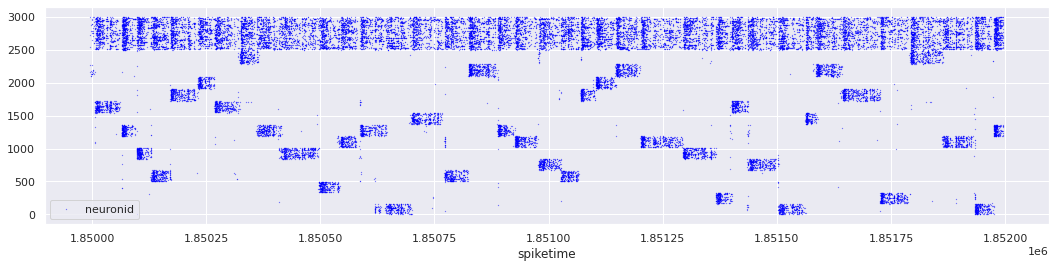

In [3]:
cell_id = 3383

spts = pd.read_csv(f'/home/roman/bucket/slurm_big_HAGAwoFD/spike_times_{cell_id}', sep=' ', header=None)
spts.columns = ['spiketime', 'neuronid']
st = spts.spiketime.min()
en = spts.spiketime.min() + 2000

with open(f'/home/roman/bucket/slurm_big_HAGAwoFD/wts_org_{cell_id}.pkl', 'rb') as f:
    w = pickle.load(f)[:2500, :2500]
w_, labels, counts, mod, newids = clusterize(w)
sub_sorted = spts.copy()
sub_sorted['neuronid'] =  spts.neuronid.map({j:i for i,j in enumerate(newids)}).fillna(spts.neuronid).astype('int')



fig, ax = plt.subplots(1,1, figsize=(18,4))
sub_sorted[(sub_sorted.spiketime >= st) & (sub_sorted.spiketime < en)].plot(x='spiketime', y='neuronid', style='o', color='blue', ms=0.2, ax=ax)



In [5]:
# make a sparse matrix of spikes out of the dataframe of spike times:
# we round spike times to nearest integer milliseconds (that's too rough)
# here we SHOULD (but don't) filter the spiketimes with a lowpass filter


Spts = csr_matrix((3000, 600000), dtype=np.bool).tolil()

spts_ = spts.to_numpy()
spts_[:,0] -= spts_[:,0].min()

for i in trange(spts_.shape[0]):
    spt = int(spts_[i,0])
    nid = int(spts_[i,1])
    Spts[nid, spt] = 1     

100%|██████████| 9684782/9684782 [00:44<00:00, 216036.01it/s]


In [ ]:
# here's the sorted sparse matrix
fig, ax = plt.subplots(1,1, figsize=(18,4))
ax.spy(Spts[newids + [i for i in range(2500, 3000)], :10000], aspect='auto', ms=0.5, origin='lower')

In [6]:
win = 10


def computeMI(i):
    """
    compute matching index ax in Romano et al. 2015, Neuron
    Non-overlapping windows
    """
    global Spts, win
    MI_row = []
    spike_places_a = np.nonzero(Spts[:, i:i+win].toarray().flatten())[0]
    for j in np.arange(0,2000, int(win)):
        spike_places_b = np.nonzero(Spts[:, j:j+win].toarray().flatten())[0]
        enumerator = len(set(spike_places_a).intersection(spike_places_b))
        denominator = len(spike_places_a) + len(spike_places_b)
        mi = 2 * enumerator/denominator
        MI_row.append(mi)
    return MI_row
    
lst = np.arange(0,2000, int(win))
with Pool(25) as p:
    MI = list(tqdm(p.imap(computeMI, lst), total=len(lst))) # with a progress bar
MI = np.stack(MI)

100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


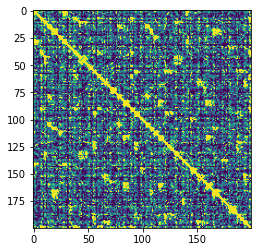

In [8]:
# plot the matching index (similar to similarit matrix)

sns.reset_orig()
plt.imshow(MI, vmax=0.03)

In [9]:
# compute the matching index on the ISI-shuffled data:

In [14]:
spts_perm = spts.copy()
spts_perm['spiketime'] -= spts_perm['spiketime'].min()
spts_perm = permuteISIs(spts_perm)

100%|██████████| 3000/3000 [03:28<00:00, 14.41it/s]


In [ ]:
# something's wrong with the bunching of spikes at the beginning of the raster. Look into that later!
fig, ax = plt.subplots(1,1, figsize=(18,4))
tmp[(tmp.spiketime < 10000)].plot(x='spiketime', y='neuronid', style='o', color='blue', ms=0.2, ax=ax)
plt.title('ISI-permuted spike data')

In [15]:
# make a sparse matrix of spikes out of the dataframe of spike times:
# we round spike times to nearest integer milliseconds (that's too rough)
# here we SHOULD (but don't) filter the spiketimes with a lowpass filter


Spts = csr_matrix((3000, 600000), dtype=np.bool).tolil()

spts_ = spts_perm.to_numpy()
spts_[:,0] -= spts_[:,0].min()

for i in trange(spts_.shape[0]):
    spt = int(spts_[i,0])
    nid = int(spts_[i,1])
    Spts[nid, spt] = 1

100%|██████████| 9684782/9684782 [00:42<00:00, 226881.63it/s]


In [16]:
# the func is the same except that it gets permuted sparse Spts and saves to MI_perm instead of MI

win = 10


def computeMI(i):
    """
    compute matching index ax in Romano et al. 2015, Neuron
    Non-overlapping windows
    """
    global Spts, win
    MI_row = []
    spike_places_a = np.nonzero(Spts[:, i:i+win].toarray().flatten())[0]
    for j in np.arange(0,2000, int(win)):
        spike_places_b = np.nonzero(Spts[:, j:j+win].toarray().flatten())[0]
        enumerator = len(set(spike_places_a).intersection(spike_places_b))
        denominator = len(spike_places_a) + len(spike_places_b)
        mi = 2 * enumerator/denominator
        MI_row.append(mi)
    return MI_row
    
lst = np.arange(0,2000, int(win))
with Pool(25) as p:
    MI_perm = list(tqdm(p.imap(computeMI, lst), total=len(lst))) # with a progress bar
MI_perm = np.stack(MI_perm)

100%|██████████| 200/200 [01:17<00:00,  2.59it/s]


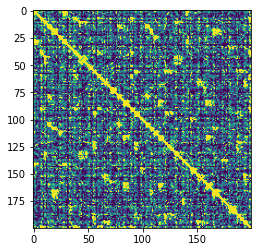

In [17]:
# plot the matching index of Permuted data (similar to similarity matrix)

sns.reset_orig()
plt.imshow(MI, vmax=0.03)

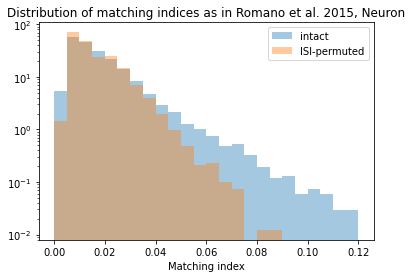

In [55]:
_ = plt.hist(MI[(MI<0.9) & (MI>0)].flatten(), bins=np.linspace(0,0.12,25), alpha=0.4, density=True, label='intact')
_ = plt.hist(MI_perm[(MI_perm<0.9) & (MI_perm>0)].flatten(), bins=np.linspace(0,0.12,25), alpha=0.4, density=True, label='ISI-permuted')
plt.gca().set_yscale('log')
plt.legend()
_ = plt.title('Distribution of matching indices as in Romano et al. 2015, Neuron')
_ = plt.xlabel('Matching index')

In [43]:
!pwd

/home/roman/deigo/H2/GRID_withFD
